**Taller 5**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import convolve
import pandas as pd
import re
from scipy.stats import gamma
from scipy.integrate import odeint

Punto 1


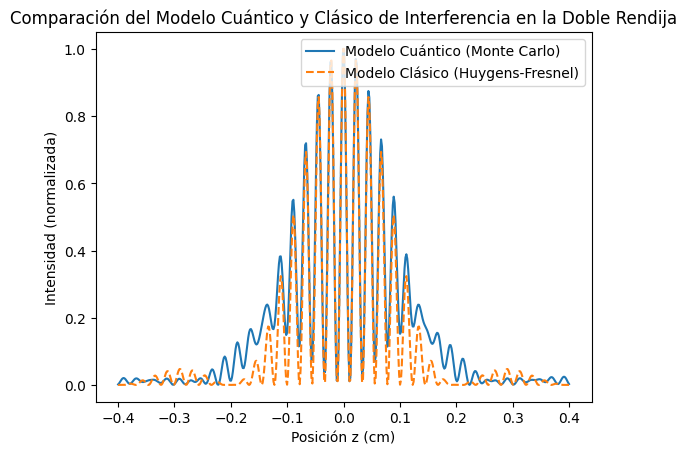

In [3]:
# Parámetros
lambda_ = 670e-9  # Longitud de onda (m)
A = 0.1e-2  # Ancho de apertura principal (m)
a = 0.01e-2  # Ancho de cada rendija (m)
d = 0.09e-2  # Separación entre las rendijas (m)
D1 = 0.3  # Distancia entre fuente y rendijas (m)
D2 = 0.3  # Distancia entre rendijas y pantalla (m)
N = 100000  # Número de muestras
z_vals = np.linspace(-0.4e-2, 0.4e-2, 500)  # Valores de z (m)

# Generación de muestras aleatorias
x_samples = np.random.uniform(-A/2, A/2, N)
y_samples = np.random.uniform(-d/2 - a/2, -d/2 + a/2, N//2)  # Primera rendija
y_samples = np.concatenate((y_samples, np.random.uniform(d/2 - a/2, d/2 + a/2, N//2)))  # Segunda rendija

# Cálculo de la intensidad cuántica
def quantum_intensity(z):
    phase = (2 * np.pi / lambda_) * (D1 + D2) + (np.pi / (lambda_ * D1)) * ((x_samples - y_samples)**2 + (z - y_samples)**2)
    integral = np.sum(np.exp(1j * phase))
    return np.abs(integral)**2

I_quantum = np.array([quantum_intensity(z) for z in z_vals])

# Normalización
I_quantum /= np.max(I_quantum)

# Cálculo del modelo clásico
theta_vals = np.arctan(z_vals / D2)
I_classic = (np.cos(np.pi * d / lambda_ * np.sin(theta_vals))**2) * (np.sinc(a / lambda_ * np.sin(theta_vals))**2)

# Normalización
I_classic /= np.max(I_classic)

# Gráfica
plt.plot(z_vals * 1e2, I_quantum, label='Modelo Cuántico (Monte Carlo)')
plt.plot(z_vals * 1e2, I_classic, label='Modelo Clásico (Huygens-Fresnel)', linestyle='--')
plt.xlabel('Posición z (cm)')
plt.ylabel('Intensidad (normalizada)')
plt.legend()
plt.title('Comparación del Modelo Cuántico y Clásico de Interferencia en la Doble Rendija')
plt.show()


Punto 2

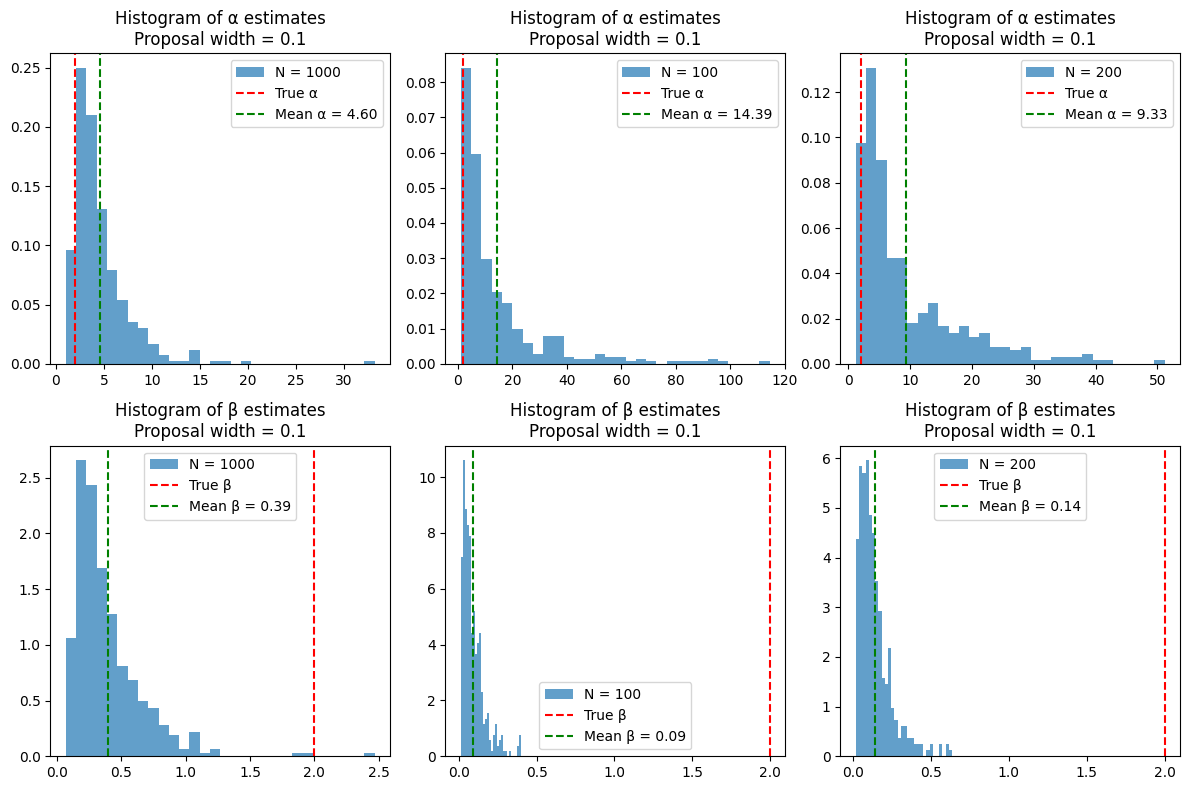

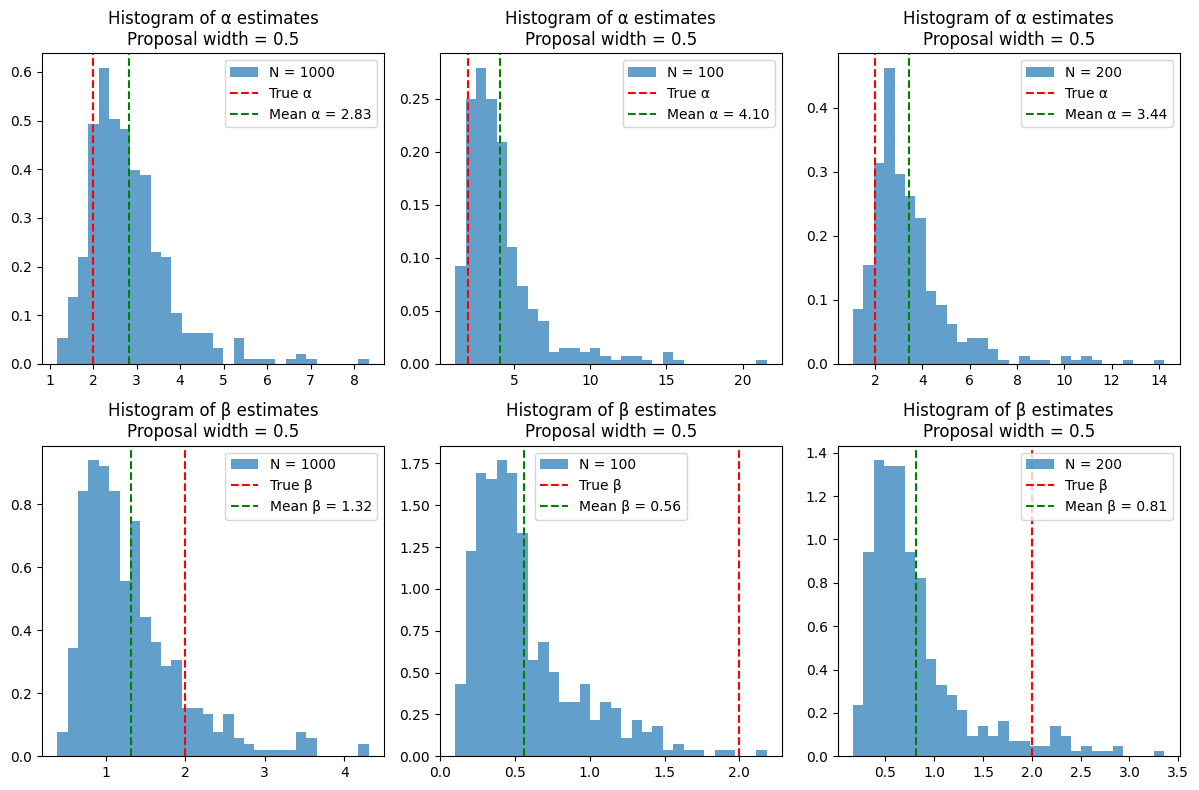

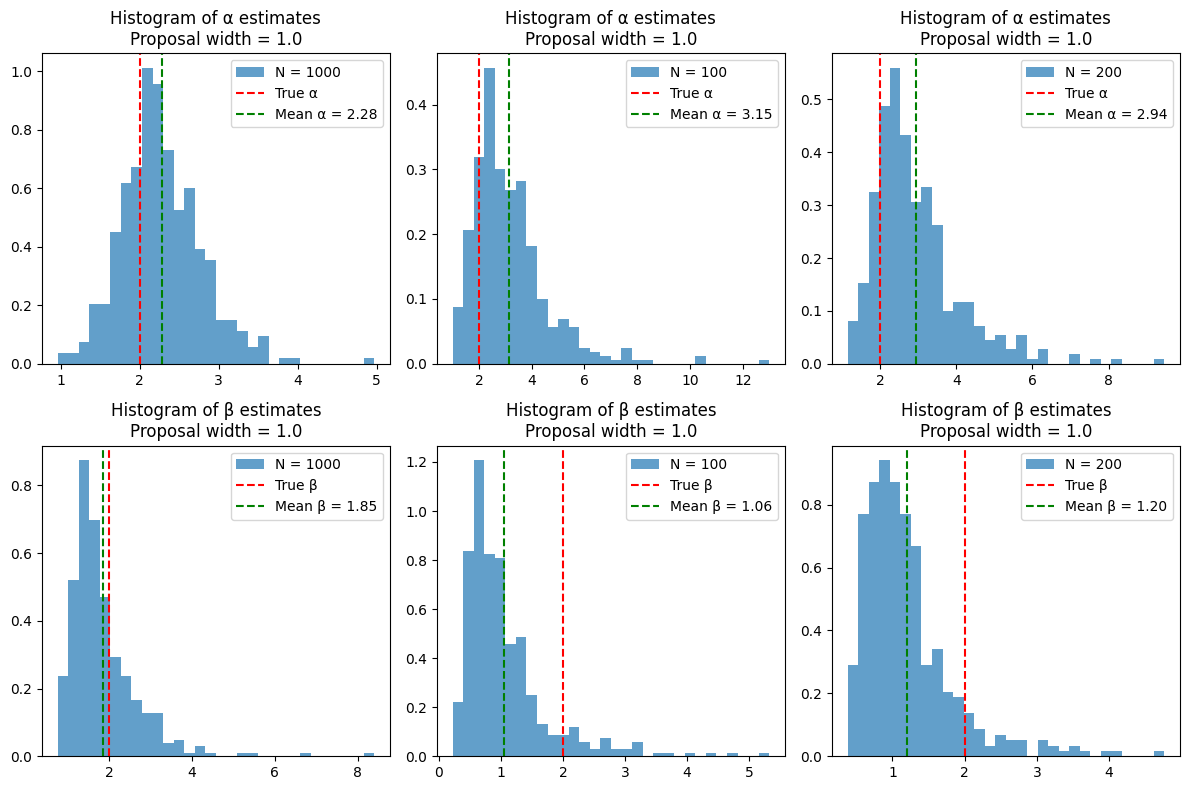

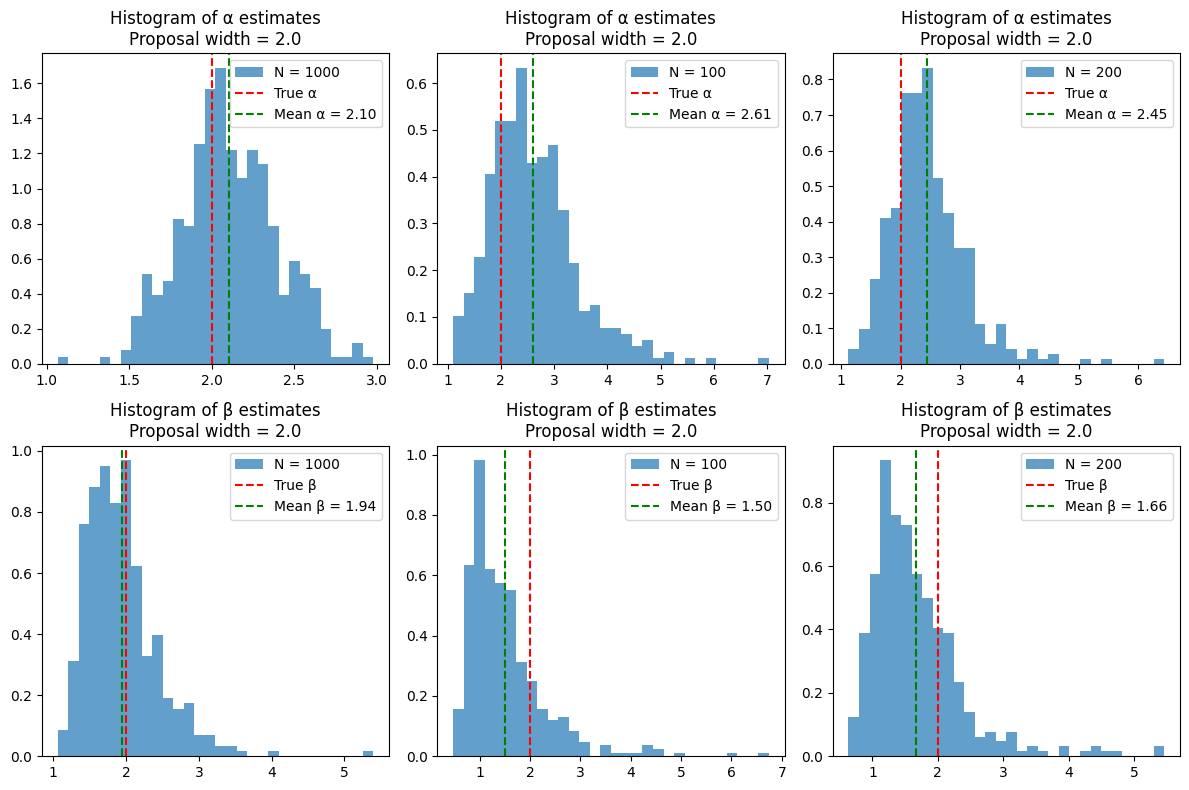

In [5]:
# Función Metrópolis-Hastings para la distribución Gamma
def metropolis_hastings(alpha, beta, N, proposal_width):
    samples = []
    x = np.random.rand()  # Valor inicial
    for _ in range(N):
        # Proponer un nuevo valor
        x_new = x + np.random.uniform(-proposal_width, proposal_width)
        if x_new > 0:  # Garantizar que x sea positivo para la distribución Gamma
            # Razón de aceptación
            acceptance_ratio = (x_new**(alpha-1) * np.exp(-x_new/beta)) / (x**(alpha-1) * np.exp(-x/beta))
            # Aceptar o rechazar
            if np.random.rand() < acceptance_ratio:
                x = x_new
        samples.append(x)
    return np.array(samples)

# Parámetros de la distribución Gamma
alpha, beta = 2.0, 2.0
N_values = [1000,100, 200]  # Diferentes números de muestras

# Pruebas con diferentes anchos de distribución de perturbación
proposal_widths = [0.1, 0.5, 1.0, 2.0]
fits_alpha = {w: {n: [] for n in N_values} for w in proposal_widths}
fits_beta = {w: {n: [] for n in N_values} for w in proposal_widths}

# Generar muestras y ajustar parámetros para cada ancho y valor de N
for proposal_width in proposal_widths:
    for N in N_values:
        for _ in range(400):  # Repetir 400 veces
            samples = metropolis_hastings(alpha, beta, N, proposal_width)
            fitted_alpha, loc, fitted_beta = gamma.fit(samples, floc=0)  # Ajustar los parámetros
            fits_alpha[proposal_width][N].append(fitted_alpha)
            fits_beta[proposal_width][N].append(fitted_beta)

# Graficar histogramas de los valores ajustados de α y β para diferentes N
for proposal_width in proposal_widths:
    plt.figure(figsize=(12, 8))

    # Graficar α
    for i, N in enumerate(N_values):
        plt.subplot(2, len(N_values), i + 1)
        plt.hist(fits_alpha[proposal_width][N], bins=30, density=True, alpha=0.7, label=f'N = {N}')
        plt.axvline(x=alpha, color='r', linestyle='--', label='True α')
        alpha_mean = np.mean(fits_alpha[proposal_width][N])
        plt.axvline(x=alpha_mean, color='g', linestyle='--', label=f'Mean α = {alpha_mean:.2f}')
        plt.title(f'Histogram of α estimates\nProposal width = {proposal_width}')
        plt.legend()

    # Graficar β
    for i, N in enumerate(N_values):
        plt.subplot(2, len(N_values), len(N_values) + i + 1)
        plt.hist(fits_beta[proposal_width][N], bins=30, density=True, alpha=0.7, label=f'N = {N}')
        plt.axvline(x=beta, color='r', linestyle='--', label='True β')
        beta_mean = np.mean(fits_beta[proposal_width][N])
        plt.axvline(x=beta_mean, color='g', linestyle='--', label=f'Mean β = {beta_mean:.2f}')
        plt.title(f'Histogram of β estimates\nProposal width = {proposal_width}')
        plt.legend()

    plt.tight_layout()
    plt.show()



Punto 3

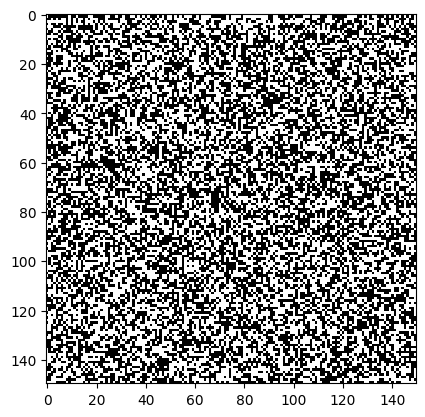

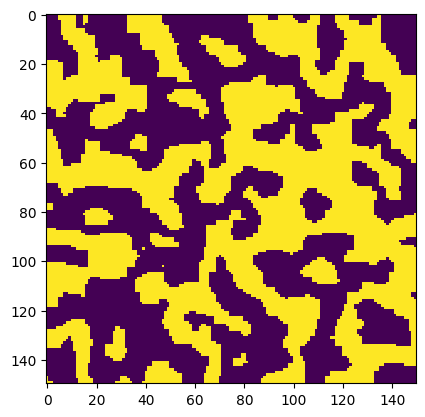

In [17]:
#Definir parametros
N = 150
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar

#Calcular energia originial
def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=15, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")
plt.show()

def fun(estado0, J):
    for i in range(400000):
        #Calular energia inical
        Eo = energia(estado0, J)

        #Sacar posición aleatoria en el array
        rand = np.random.randint(N, size=(2))

        #Cambiar el valor de la posición
        estado1 = estado0.copy()
        estado1[rand[0], rand[1]] *= -1

        #Calcular la energia nueva
        En = energia(estado1, J)

        #Aplicar condiciones
        dE = En - Eo

        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            estado0 = estado1
    return estado1

plt.imshow(fun(estado0=estado0, J=J), interpolation="nearest")
plt.show()


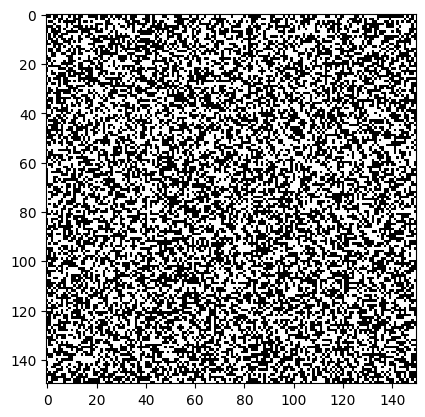

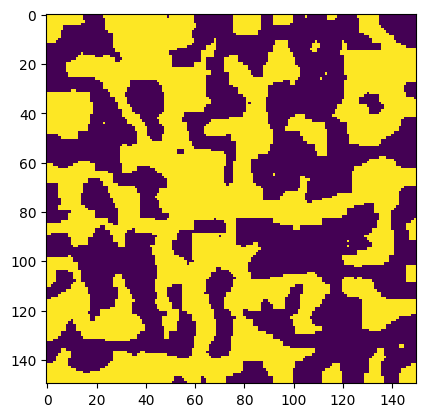

In [18]:
#Definir parametros
N = 150
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar
plt.imshow(estado0, cmap="Greys",  interpolation="nearest")
plt.show()
#Calcular energia originial

def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=5, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")

with writer.saving(fig, "Modelo Ising con Metropolis.mp4", 200):
    for i in range(400000):
        #Calular energia inical
        Eo = energia(estado0, J)

        #Sacar posición aleatoria en el array
        rand = np.random.randint(N, size=(2))

        #Cambiar el valor de la posición
        estado1 = estado0.copy()
        estado1[rand[0], rand[1]] *= -1

        #Calcular la energia nueva
        En = energia(estado1, J)

        #Aplicar condiciones
        dE = En - Eo

        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            estado0 = estado1

        if i % 10000 == 0:
            ax.imshow(estado1, interpolation="nearest")
            writer.grab_frame()


**AVISO**
Debido a problemas de compatibilidad, La animación se subio al repositorio como un archivo separado. Por favor dirigirse al archivo "Modelo Ising con Metropolis.mp4" para ver la animación correspondiente a este punto.

Punto 4

*4.1*

In [16]:
#Importar el Libro
with open("Alice in Wonderland.txt", "r", encoding="utf-8") as file:
    libro = file.read()

In [17]:
#Limpiar el libro
import re
libro_limpio = libro.replace("\r\n", "\n").replace("\n\n", "#").replace("\n", " ").replace("#", "\n\n")
libro_limpio = re.sub(r"[^\w\s.,;:?!\n]", "", libro_limpio)
libro_limpio = re.sub(r" {2,}", " ", libro_limpio)
libro_limpio = re.sub(r"ù", "u", libro_limpio)
libro_limpio = re.sub(r"_", "", libro_limpio)
libro_limpio = libro_limpio.lower()
#Quite la primera y ultima parte del libro a mano

#print(libro_limpio[:500])

*4.2*

In [18]:
np.unique(list(libro_limpio))

array(['\n', ' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e',
       'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [19]:
n=3
np.unique([libro_limpio[i:i+n] for i in range(len(libro_limpio)-n)]) #Me da las combinaciones unicas de n caracteres

array(['\n\n\n', '\n\n ', '\n\na', ..., 'zy ', 'zy!', 'zzl'], dtype='<U3')

In [89]:
#Parametros
n = 3
caracteres = sorted(set("abcdefghijklmnopqrstuvwxyz .,;:?!\n"))
unicos = np.unique([libro_limpio[i:i+n] for i in range(len(libro_limpio)-n)]) #Me da las combinaciones unicas de n caracteres
ngramas = []
for i in unicos:
    ngramas.append(str(i))
#print(ngramas)

#Creando DataFrame
F = pd.DataFrame(np.zeros((len(ngramas), len(caracteres)), dtype=int), index=ngramas, columns=caracteres)

for i in range(len(libro_limpio) - n):
    posicion = libro_limpio[i:i+n]
    posicion_sig = libro_limpio[i+n]
    #if posicion in ngramas and posicion_sig in caracteres:
    #print(posicion, posicion_sig)
    F.loc[posicion, posicion_sig] += 1









P = F / F.sum(axis=1).values[:,None]

display(P)

['\n\n\n', '\n\n ', '\n\na', '\n\nb', '\n\nc', '\n\nd', '\n\ne', '\n\nf', '\n\ng', '\n\nh', '\n\ni', '\n\nj', '\n\nk', '\n\nl', '\n\nm', '\n\nn', '\n\no', '\n\np', '\n\nr', '\n\ns', '\n\nt', '\n\nu', '\n\nv', '\n\nw', '\n\ny', '\n \n', '\n a', '\n b', '\n c', '\n f', '\n h', '\n i', '\n t', '\n w', '\n y', '\na ', '\naf', '\nah', '\nal', '\nan', '\nar', '\nas', '\nat', '\nba', '\nbe', '\nbo', '\nbu', '\nby', '\nca', '\nce', '\nch', '\nco', '\ndi', '\ndo', '\nea', '\nei', '\nev', '\nex', '\nfi', '\nfo', '\nge', '\ngi', '\ngo', '\nha', '\nhe', '\nho', '\nhu', '\ni ', '\nid', '\nif', '\nii', '\nil', '\nim', '\nin', '\nis', '\nit', '\niv', '\nju', '\nke', '\nla', '\nle', '\nlu', '\nma', '\nmi', '\nmy', '\nne', '\nno', '\nof', '\noh', '\non', '\nor', '\npe', '\npl', '\npo', '\npr', '\nre', '\nri', '\nse', '\nsh', '\nsi', '\nso', '\nsp', '\nst', '\nsu', '\nsw', '\nta', '\nte', '\nth', '\nti', '\nto', '\ntr', '\ntu', '\ntw', '\nug', '\nun', '\nup', '\nve', '\nwa', '\nwe', '\nwh', '\nwi', '\nw

,\n,,!,",",.,:,;,?,a,b,...,q,r,s,t,u,v,w,x,y,z
\n\n\n,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
\n\n,0.169811,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.056604,0.018868,...,0.0,0.000000,0.000000,0.169811,0.000000,0.0,0.09434,0.0,0.037736,0.0
\n\na,0.000000,0.067961,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.038835,0.087379,0.048544,0.000000,0.0,0.00000,0.0,0.000000,0.0
\n\nb,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,...,0.0,0.000000,0.000000,0.000000,0.619048,0.0,0.00000,0.0,0.142857,0.0
\n\nc,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.235294,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zle,0.000000,0.000000,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
zli,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
zy,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
zy!,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0


Punto 5

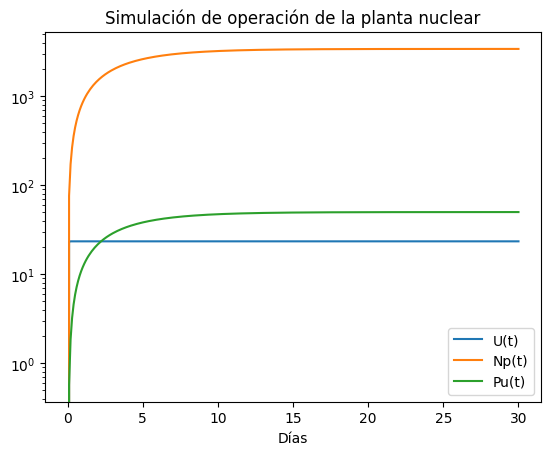

No se alcanzó un estado estable durante la simulación.


In [12]:
# Parámetros del problema
A = 1000  # Producción diaria de U239
B = 20    # Extracción diaria de Pu239
t_half_U = 23.4 / (24 * 60)  # Vida media de U239 en días
t_half_Np = 2.36  # Vida media de Np239 en días

# Constantes de decaimiento (lambda)
lambda_U = np.log(2) / t_half_U
lambda_Np = np.log(2) / t_half_Np

# Tiempo de simulación en días
days = 30
t = np.linspace(0, days, 300)  # Puntos de tiempo en días

# Sistema de ecuaciones diferenciales
def sistema(y, t, A, lambda_U, lambda_Np, B):
    U, Np, Pu = y
    dU_dt = A - lambda_U * U
    dNp_dt = lambda_U * U - lambda_Np * Np
    dPu_dt = lambda_Np * Np - B * Pu
    return [dU_dt, dNp_dt, dPu_dt]

# Condiciones iniciales (Planta completamente limpia)
y0 = [0, 0, 0]

# Solución del sistema de ecuaciones
sol = odeint(sistema, y0, t, args=(A, lambda_U, lambda_Np, B))

# Extraer las soluciones para U, Np, y Pu
U = sol[:, 0]
Np = sol[:, 1]
Pu = sol[:, 2]

# Graficar resultados
plt.plot(t, U, label="U(t)")
plt.plot(t, Np, label="Np(t)")
plt.plot(t, Pu, label="Pu(t)")
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Días')
plt.legend()
plt.title('Simulación de operación de la planta nuclear')
plt.show()

# Detección de estado estable
tolerancia = 1e-3  # Tolerancia para la comparación
estado_estable_dias = None
for i in range(1, len(t)):
    if abs(U[i] - U[i-1]) < tolerancia and abs(Np[i] - Np[i-1]) < tolerancia and abs(Pu[i] - Pu[i-1]) < tolerancia:
        estado_estable_dias = t[i]
        print(f"Estado estable alcanzado en {estado_estable_dias:.2f} días")
        break

if estado_estable_dias is None:
    print("No se alcanzó un estado estable durante la simulación.")


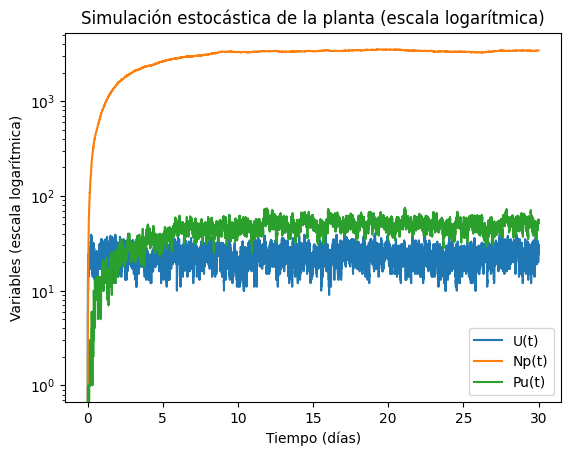

In [13]:
# Parámetros del problema
A = 1000         # Tasa de introducción de U
B = 20           # Tasa de eliminación de Pu

# Constantes de decaimiento
t_half_U = 23.4 / 1440  # Vida media de U (en días), 23.4 min = 23.4 / 1440 días
t_half_Np = 2.36        # Vida media de Np (en días)

lambda_U = np.log(2) / t_half_U  # Tasa de reacción U -> Np
lambda_Np = np.log(2) / t_half_Np  # Tasa de reacción Np -> Pu

time_limit = 30  # Simulación por 30 días

# Vectores de cambio de estado R
R = np.array([[1, 0, 0],   # Evento 1: Introducción de U
              [-1, 1, 0],  # Evento 2: U -> Np
              [0, -1, 1],  # Evento 3: Np -> Pu
              [0, 0, -1]]) # Evento 4: Eliminación de Pu

# Condiciones iniciales
Y = np.array([0, 0, 0])  # [U, Np, Pu] iniciales
t = 0  # Tiempo inicial

# Historial para graficar
time_history = [t]
U_history = [Y[0]]
Np_history = [Y[1]]
Pu_history = [Y[2]]

# Simulación estocástica
while t < time_limit:
    # Calcular las tasas actuales
    Tasas = np.array([A, lambda_U * Y[0], lambda_Np * Y[1], B * Y[2]])
    total_rate = np.sum(Tasas)

    if total_rate == 0:
        break  # No hay más eventos posibles

    # Tiempo hasta la siguiente reacción
    tau = np.random.exponential(1 / total_rate)

    # Elegir la reacción según las probabilidades
    probabilities = Tasas / total_rate
    reaction = np.random.choice(len(R), p=probabilities)

    # Aplicar la reacción al estado del sistema
    Y += R[reaction]

    # Asegurarse de que los valores no sean negativos
    Y = np.maximum(Y, 0)

    # Evolucionar el tiempo
    t += tau

    # Guardar el estado actual del sistema
    time_history.append(t)
    U_history.append(Y[0])
    Np_history.append(Y[1])
    Pu_history.append(Y[2])

# Graficar los resultados en escala logarítmica
plt.plot(time_history, U_history, label='U(t)')
plt.plot(time_history, Np_history, label='Np(t)')
plt.plot(time_history, Pu_history, label='Pu(t)')
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (300,)

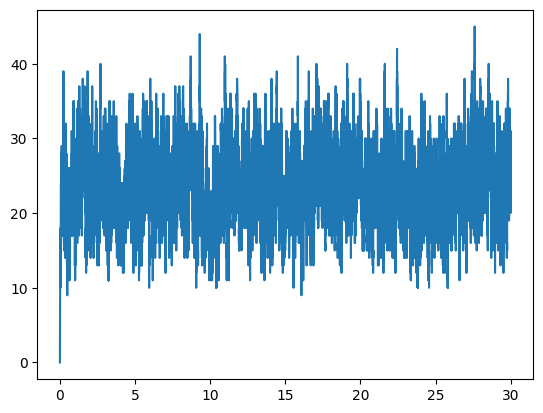

In [14]:
plt.plot(time_history, U_history, label='U(t) Estocástico')
plt.plot(t, U, label="U(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')
plt.show()

plt.plot(time_history, Np_history, label='Np(t) Estocástico')
plt.plot(t, Np, label="Np(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')

plt.show()
plt.plot(time_history, Pu_history, label='Pu(t) Estocástico')
plt.plot(t, Pu, label="Pu(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')


In [11]:
# Función para realizar la simulación estocástica
def simular(A, B, lambda_U, lambda_Np, time_limit):
    # Vectores de cambio de estado R
    R = np.array([[1, 0, 0],   # Evento 1: Introducción de U
                  [-1, 1, 0],  # Evento 2: U -> Np
                  [0, -1, 1],  # Evento 3: Np -> Pu
                  [0, 0, -1]]) # Evento 4: Eliminación de Pu

    # Condiciones iniciales
    Y = np.array([0, 0, 0])  # [U, Np, Pu] iniciales
    t = 0  # Tiempo inicial

    # Simulación estocástica
    while t < time_limit:
        # Calcular las tasas actuales
        Tasas = np.array([A, lambda_U * Y[0], lambda_Np * Y[1], B * Y[2]])
        total_rate = np.sum(Tasas)

        if total_rate == 0:
            break  # No hay más eventos posibles

        # Tiempo hasta la siguiente reacción
        tau = np.random.exponential(1 / total_rate)

        # Elegir la reacción según las probabilidades
        probabilities = Tasas / total_rate
        reaction = np.random.choice(len(R), p=probabilities)

        # Aplicar la reacción al estado del sistema
        Y += R[reaction]

        # Asegurarse de que los valores no sean negativos
        Y = np.maximum(Y, 0)

        # Evolucionar el tiempo
        t += tau

        # Verificar si Pu alcanza o supera 80
        if Y[2] >= 80:
            return True  # Se alcanzó el umbral de Pu
    return False  # No se alcanzó el umbral de Pu

num_simulaciones = 100

# Contador de simulaciones exitosas (Pu >= 80)
contador_exitos = 0

# Ejecutar múltiples simulaciones
for _ in range(num_simulaciones):
    if simular(A, B, lambda_U, lambda_Np, time_limit):
        contador_exitos += 1

# Calcular la probabilidad
probabilidad = contador_exitos / num_simulaciones

# Mostrar el resultado
print(f"La probabilidad de que el nivel de Pu llegue a ser igual o mayor a 80 es {probabilidad:.4f}")

La probabilidad de que el nivel de Pu llegue a ser igual o mayor a 80 es 0.1800
